# 学习Pandas，第 3 课
> 英文原文: [03 - Lesson](http://nbviewer.ipython.org/urls/bitbucket.org/hrojas/learn-pandas/raw/master/lessons/03%20-%20Lesson.ipynb)


**获取数据** - 我们的数据在一个 Excel 文件中，包含了每一个日期的客户数量。 我们将学习如何读取 Excel 文件的内容并处理其中的数据。  
**准备数据** - 这组时间序列的数据并不规整而且有重复。 我们的挑战是整理这些数据并且预测下一个年度的客户数。  
**分析数据** - 我们将使用图形来查看趋势情况和离群点。我们会使用一些内置的计算工具来预测下一年度的客户数。  
**表现数据** - 结果将会被绘制成图形。 


***注意:  确保你已经看过了之前的课程，这里的一些练习会需要你在之前课程学到的那些知识。***  

In [1]:
# 导入所需要的库
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as np
import sys
import matplotlib

%matplotlib inline

In [2]:
print('Python version ' + sys.version)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.1 | packaged by conda-forge | (default, Mar 23 2017, 21:57:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
Pandas version: 0.19.2
Matplotlib version 2.0.2


> 我们将创建一些测试数据用来分析

In [3]:
# 设置种子
np.seed(111)

# 生成测试数据的函数
def CreateDataSet(Number=1):
    
    Output = []
    
    for i in range(Number):
        
        # 创建一个按周计算的日期范围(每周一起始)
        rng = pd.date_range(start='1/1/2009', end='12/31/2012', freq='W-MON')
        
        # 创建一些随机数
        data = np.randint(low=25, high=1000, size=len(rng))
        
        # 状态池
        status = [1, 2, 3]
        
        # 创建一个随机的状态列表
        random_status = [status[np.randint(low=0, high=len(status))] for i in range(len(rng))]
        
        # 行政州(state)的列表
        states = ['GA','FL','fl','NY','NJ','TX']
        
        # 创建一个行政周的随机列表
        random_states = [states[np.randint(low=0, high=len(states))] for i in range(len(rng))]
    
        Output.extend(zip(random_states, random_status, data, rng))
        
    return Output

现在我们有了一个生成测试数据的函数，我们来创建一些数据并放到一个 dataframe 中。

In [4]:
dataset = CreateDataSet(4)
df = pd.DataFrame(data=dataset, columns=['State','Status','CustomerCount','StatusDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 4 columns):
State            836 non-null object
Status           836 non-null int64
CustomerCount    836 non-null int64
StatusDate       836 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 26.2+ KB


In [5]:
df.head()

,State,Status,CustomerCount,StatusDate
0,GA,1,877,2009-01-05
1,FL,1,901,2009-01-12
2,fl,3,749,2009-01-19
3,FL,3,111,2009-01-26
4,GA,1,300,2009-02-02


现在我们将这个 dataframe 保存到 Excel 文件中，然后再读取出来放回到 dataframe 中。 我们简单地展示一下如何读写 Excel 文件。

我们不会把索引值(index)写到 Excel 文件中，这些索引值不是我们的测试数据的一部分。

In [6]:
# 结果保存到 Excel 中。 译者注: 需要 openpyxl 包
df.to_excel('Lesson3.xlsx', index=False) #不保存索引，但是保存列名(column header)
print('Done')

Done


# 从 Excel 中获取数据

我们用 ***read_excel*** 这个函数从 Excel 文件读取数据。 这个函数允许按照页签的名字或者位置来选择特定的页签(译者注: 即Excel中的sheet)。

In [7]:
pd.read_excel?

**注意: 除非指定目录，Excel 文件从与 notebook 相同的目录读取。***

In [8]:
# 文件的位置
Location = r'./Lesson3.xlsx'

# 读取第一个页签(sheet)，并指定索引列是 StatusDate
df = pd.read_excel(Location, sheetname=0, index_col='StatusDate')  #译者注: 需要 xlrd 包
df.dtypes

State            object
Status            int64
CustomerCount     int64
dtype: object

In [9]:
df.index

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09',
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name='StatusDate', length=836, freq=None)

In [10]:
df.head()

,State,Status,CustomerCount
StatusDate,,,
2009-01-05,GA,1,877
2009-01-12,FL,1,901
2009-01-19,fl,3,749
2009-01-26,FL,3,111
2009-02-02,GA,1,300


# 准备数据

这一部分，我们尝试将数据进行清洗以备分析:

1. 确保 state 列都是大写  
2. 只选择 Status = 1 的那些记录  
3. 对 State 列中的 NJ 和 NY，都合并为 NY
4. 去除一些离群中 (数据集中一些特别奇异的结果)

让我们先快速看一下 *State* 列中的大小写情况。

In [11]:
df['State'].unique()

array(['GA', 'FL', 'fl', 'TX', 'NY', 'NJ'], dtype=object)

我们用 ***upper()*** 函数和 dataframe 的 ***apply*** 属性将 State 的值都转换为大写。 ***lambda*** 函数简单地将`upper()`函数应用到 *State* 列中的每一个值上。

In [12]:
# 清洗 State 列，全部转换为大写
df['State'] = df.State.apply(lambda x: x.upper())

In [13]:
df['State'].unique()

array(['GA', 'FL', 'TX', 'NY', 'NJ'], dtype=object)

In [14]:
# 只保留 Status == 1
mask = df['Status'] == 1
df = df[mask]

将 ***NJ*** 转换为 ***NY***，仅需简单地:

***[df.State == 'NJ']*** - 找出 ***State*** 列是 *NJ* 的所有记录。   
***df.State[df.State == 'NJ'] = 'NY'*** - 对 ***State*** 列是 *NJ* 的所有记录，将其替换为 *NY*。  

In [15]:
# 将 NJ 转换为 NY
mask = df.State == 'NJ'
df['State'][mask] = 'NY'

现在我们看一下，我们有了一个更加干净的数据集了。

In [16]:
df['State'].unique()

array(['GA', 'FL', 'NY', 'TX'], dtype=object)

这是也许我们可以将数据绘制成图形查看一下数据中是否有任何离群值(outliers)或者不一致(inconsistencies)。 我们使用 dataframe 中的 ***plot()*** 函数。

从下图你可以看到图形没有说明什么，这也许是一个信号我们需要做更多的数据处理。

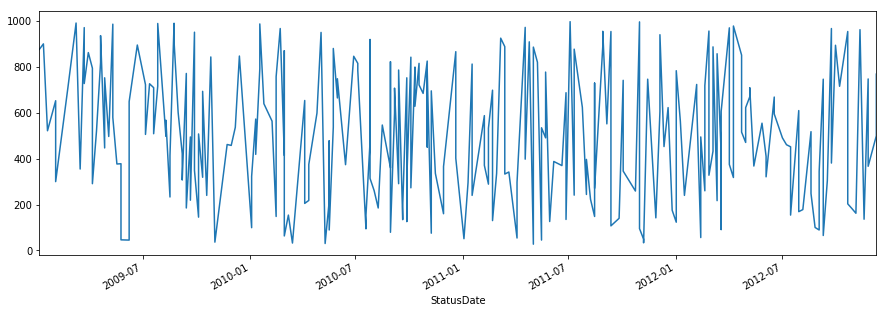

In [17]:
df['CustomerCount'].plot(figsize=(15,5));

如果我们看这些数据，我们会意识到同一个 State, StatusDate 和 Status 的组合会有多个值。 这可能意味着我们在处理的数据是脏数据/坏数据/不精确的数据(dirty/bad/inaccurate)，但我们不这样假设。 我们假设这个数据集是一个更大更大数据集的一个子集(subset)，并且如果我们简单的将 State, StatusDate 和 Status 组合下的 ***CustomerCount*** 累加起来, 我们将得到每一天的 ***全部客户数量*** (Total Customer Count)。

In [18]:
sortdf = df[df['State']=='NY'].sort_index(axis=0)
sortdf.head(10)

,State,Status,CustomerCount
StatusDate,,,
2009-01-19,NY,1,522
2009-02-23,NY,1,710
2009-03-09,NY,1,992
2009-03-16,NY,1,355
2009-03-23,NY,1,728
2009-03-30,NY,1,863
2009-04-13,NY,1,520
2009-04-20,NY,1,820
2009-04-20,NY,1,937


我们的任务是创建一个新的 dataframe，然后对数据进行压缩处理，是的每一个 State 和 StatusDate 组合代表一天的客户数量。 我们可以忽略 Status 列因为这一列我们之前处理过只有 *1* 这个值了。 要完成这个操作，我们使用 dataframe 的 ***groupyby()*** 和 ***sum()*** 这两个函数。

注意，我们要使用 ***reset_index***。 如果我们不这么做，我们将无法同时用 State 和 StatusDate 这两列来做分组，因为 groupby 函数需要列(columns)来做为输入(译者注: StatusDate 目前是 index，不是 column)。 **reset_index** 函数将把 dataframen 中作为索引(index)的 ***StatusDate*** 变回普通的列。

In [19]:
# 先 reset_index，然后按照 State 和 StatusDate 来做分组 (groupby)
Daily = df.reset_index().groupby(['State','StatusDate']).sum()
Daily.head()

Status  CustomerCount
State StatusDate                       
FL    2009-01-12       1            901
      2009-02-02       1            653
      2009-03-23       1            752
      2009-04-06       2           1086
      2009-06-08       1            649

在 ***Daily*** 这个 dataframe 中，***State*** 和 ***StatusDate*** 这两列被自动设置为了索引(index)。 你可以将 ***index*** 设想为数据库表中的逐渐(primary key)，只不过没有唯一性(unique)的限制。 索引中的这些列让我们更容易的可以选择，绘图和执行一些计算。

接下去我们将 ***Status*** 删掉，它的值就是 *1*，没有多少用途了。

In [20]:
del Daily['Status']
Daily.head()

CustomerCount
State StatusDate               
FL    2009-01-12            901
      2009-02-02            653
      2009-03-23            752
      2009-04-06           1086
      2009-06-08            649

In [21]:
# 看一下 dataframe 中的索引(index)
Daily.index

MultiIndex(levels=[['FL', 'GA', 'NY', 'TX'], [2009-01-05 00:00:00, 2009-01-12 00:00:00, 2009-01-19 00:00:00, 2009-02-02 00:00:00, 2009-02-23 00:00:00, 2009-03-09 00:00:00, 2009-03-16 00:00:00, 2009-03-23 00:00:00, 2009-03-30 00:00:00, 2009-04-06 00:00:00, 2009-04-13 00:00:00, 2009-04-20 00:00:00, 2009-04-27 00:00:00, 2009-05-04 00:00:00, 2009-05-11 00:00:00, 2009-05-18 00:00:00, 2009-05-25 00:00:00, 2009-06-08 00:00:00, 2009-06-22 00:00:00, 2009-07-06 00:00:00, 2009-07-13 00:00:00, 2009-07-20 00:00:00, 2009-07-27 00:00:00, 2009-08-10 00:00:00, 2009-08-17 00:00:00, 2009-08-24 00:00:00, 2009-08-31 00:00:00, 2009-09-07 00:00:00, 2009-09-14 00:00:00, 2009-09-21 00:00:00, 2009-09-28 00:00:00, 2009-10-05 00:00:00, 2009-10-12 00:00:00, 2009-10-19 00:00:00, 2009-10-26 00:00:00, 2009-11-02 00:00:00, 2009-11-23 00:00:00, 2009-11-30 00:00:00, 2009-12-07 00:00:00, 2009-12-14 00:00:00, 2010-01-04 00:00:00, 2010-01-11 00:00:00, 2010-01-18 00:00:00, 2010-01-25 00:00:00, 2010-02-08 00:00:00, 2010-02-1

In [22]:
# 选择 State 这个索引
Daily.index.levels[0]

Index(['FL', 'GA', 'NY', 'TX'], dtype='object', name='State')

In [23]:
# 选择 StatusDate 这个索引
Daily.index.levels[1]

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-02-02',
               '2009-02-23', '2009-03-09', '2009-03-16', '2009-03-23',
               '2009-03-30', '2009-04-06',
               ...
               '2012-09-24', '2012-10-01', '2012-10-08', '2012-10-22',
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-10'],
              dtype='datetime64[ns]', name='StatusDate', length=161, freq=None)

我们按照每一个州来绘制一下图表。

正如你所看到的，将图表按照不同的 ***State*** 区分开，我们能看到更清晰的数据。 你能看到任何离群值(outlier)吗?

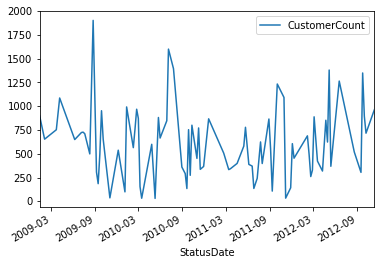

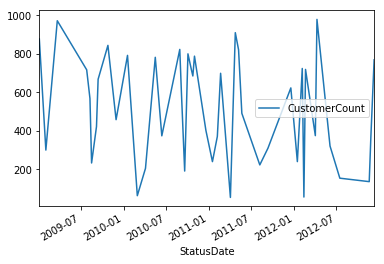

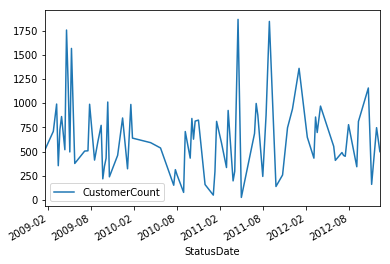

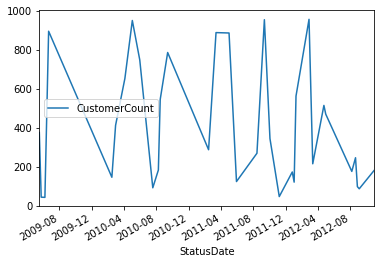

In [24]:
Daily.loc['FL'].plot()
Daily.loc['GA'].plot()
Daily.loc['NY'].plot()
Daily.loc['TX'].plot();

我们也可以指定一个日期，比如 ***2012***，来绘制图表。 
We can also just plot the data on a specific date, like ***2012***.  我们能够清晰地看到这些州的数据分布很广。 因为这些数据包含了每周的客户数量，数据的变化情况看上去是可以预测的。 在这个教程里面，我们假设没有坏数据并继续往下。

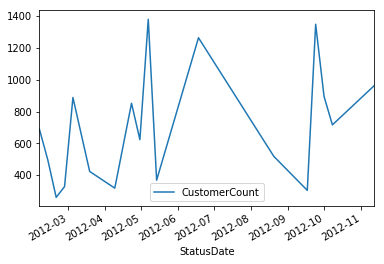

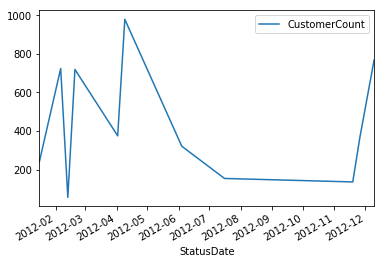

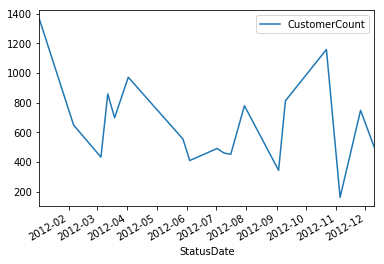

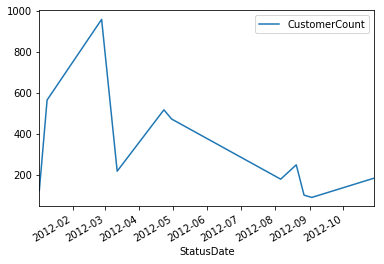

In [25]:
Daily.loc['FL']['2012':].plot()
Daily.loc['GA']['2012':].plot()
Daily.loc['NY']['2012':].plot()
Daily.loc['TX']['2012':].plot();

我们假设每个月的客户数量应该是保持相对稳定的。 在一个月内任何在这个特定范围之外的数据都可以从数据集中移除。 最终的结果应该更加的平滑并且图形不会有尖刺。


***StateYearMonth*** - 这里我们通过 State, StatusDate 中的年份(year)和月份(Month) 来分组。    
***Daily['Outlier']*** - 一个布尔(boolean)变量值 (True 或者 False)，从而我们会知道 CustomerCount 值是否在一个可接受的范围之内。

我们将会用到 ***transform*** 而不是 ***apply***。 原因是， transform 将会保持 dataframe 矩阵的形状(shape)(就是行列数不变)而 apply 会改变矩阵的形状。 看过前面的图形我们意识到这些图形不是高斯分布的(gaussian distribution)，这意味着我们不能使用均值(mean)和标准差(stDev)这些统计量。 我们将使用百分位数(percentile)。 请注意这里也会有把好数据消除掉的风险。

In [26]:
# 计算离群值
StateYearMonth = Daily.groupby([Daily.index.get_level_values(0), Daily.index.get_level_values(1).year, Daily.index.get_level_values(1).month])
Daily['Lower'] = StateYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.25) - (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Upper'] = StateYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.75) + (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Outlier'] = (Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper']) 

# 移除离群值
Daily = Daily[Daily['Outlier'] == False]

***Daily*** 这个 dataframe 按照每天来汇总了客户数量。 而原始的数据则可能每一天会有多个记录。 我们现在保留下一个用 State 和 StatusDate 来做索引的数据集。 Outlier 列如果是 ***False*** 的化代表这条记录不是一个离群值。

In [27]:
Daily.head()

CustomerCount  Lower   Upper Outlier
State StatusDate                                      
FL    2009-01-12            901  450.5  1351.5   False
      2009-02-02            653  326.5   979.5   False
      2009-03-23            752  376.0  1128.0   False
      2009-04-06           1086  543.0  1629.0   False
      2009-06-08            649  324.5   973.5   False

我们创建一个单独的 dataframe，叫 ***ALL***，仅用 StatusDate 来为 Daily 数据集做索引。 我们简单地去掉 ***State*** 这一列。 ***Max*** 列则代表了每一个月最大的客户数量。 ***Max*** 列是用来是的图形更顺滑的。

In [28]:
# 合并所有市场的

# 按日期计算出最大的客户数
ALL = pd.DataFrame(Daily['CustomerCount'].groupby(Daily.index.get_level_values(1)).sum())
ALL.columns = ['CustomerCount'] # rename column

# 按照年和月来分组
YearMonth = ALL.groupby([lambda x: x.year, lambda x: x.month])

# 找出每一个年和月的组合中最大的客户数
ALL['Max'] = YearMonth['CustomerCount'].transform(lambda x: x.max())
ALL.head()

,CustomerCount,Max
StatusDate,,
2009-01-05,877,901
2009-01-12,901,901
2009-01-19,522,901
2009-02-02,953,953
2009-02-23,710,953


从上面的 ***ALL*** dataframe 中可以看到，在 2009年1月的这个月份，最大的客户数是 901。 如果我们使用 ***apply*** 的方式，我们将会得到一个以 (年 和 月）组合作为索引的 dataframe ，只有 *Max* 这一列有901这个值。

----------------------------------
如果当前的客户数达到了公司制定的一定的目标值，这也会是一个很有趣的度量值。 现在的任务是可视化的展示当前的客户数是否达到了下面列出的目标值。 我们把这些目标叫做 ***BHAG*** (Big Hairy Annual Goal，年度战略目标)。

* 12/31/2011 - 1,000 客户  
* 12/31/2012 - 2,000 客户  
* 12/31/2013 - 3,000 客户  

我们将用 ***date_range*** 函数来创建日期。


***定义:*** date_range(start=None, end=None, periods=None, freq='D', tz=None, normalize=False, name=None, closed=None)  
***文档(Docstring):*** 返回一个固定频率的日期时间索引，用日历天作为默认的频率

把频率设定为 ***A*** 或者是“年度” 我们将等到上述三个年份。

In [29]:
pd.date_range?

In [30]:
# 创建 BHAG 数据
data = [1000, 2000, 3000]
idx = pd.date_range(start='12/31/2011', end='12/31/2013', freq='A')
BHAG = pd.DataFrame(data, index=idx, columns=['BHAG'])
BHAG

,BHAG
2011-12-31,1000
2012-12-31,2000
2013-12-31,3000


我们之前学过用 ***concat*** 把 dataframe 合并。 记住，当我们设置 ***axis = 0*** 时我们按列合并 (row wise, 译者注: 即直接把列合并进去，行方向数据缺失用NaN来填充）。

In [31]:
# 把 BHAG 和 ALL 两个数据集合并在一起
combined = pd.concat([ALL,BHAG], axis=0)
combined = combined.sort_index(axis=0)
combined.tail()

,BHAG,CustomerCount,Max
2012-11-19,NaN,136.0,1115.0
2012-11-26,NaN,1115.0,1115.0
2012-12-10,NaN,1269.0,1269.0
2012-12-31,2000.0,NaN,NaN
2013-12-31,3000.0,NaN,NaN


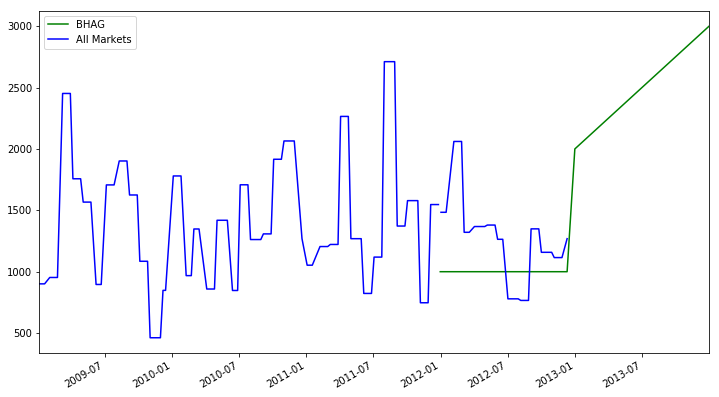

In [32]:
fig, axes = plt.subplots(figsize=(12, 7))

combined['BHAG'].fillna(method='pad').plot(color='green', label='BHAG')
combined['Max'].plot(color='blue', label='All Markets')
plt.legend(loc='best');

这里还有一个需求是预测下一个年度的客户数，我们之后会通过几个简单的步骤完成。 我们想把已经***合并***的 dataframe 按照 ***Year*** 来分组，并且计算出年度的最大客户数。 这样每一行就是一个年度的数据。

In [33]:
# Group by Year and then get the max value per year
Year = combined.groupby(lambda x: x.year).max()
Year

,BHAG,CustomerCount,Max
2009,NaN,2452.0,2452.0
2010,NaN,2065.0,2065.0
2011,1000.0,2711.0,2711.0
2012,2000.0,2061.0,2061.0
2013,3000.0,NaN,NaN


In [34]:
# 增加一列，表示为每一年比上一年变化的百分比
Year['YR_PCT_Change'] = Year['Max'].pct_change(periods=1)
Year

,BHAG,CustomerCount,Max,YR_PCT_Change
2009,NaN,2452.0,2452.0,NaN
2010,NaN,2065.0,2065.0,-0.157830
2011,1000.0,2711.0,2711.0,0.312833
2012,2000.0,2061.0,2061.0,-0.239764
2013,3000.0,NaN,NaN,NaN


要得到下一个年度末的客户数，我们假定当前的增长速率是维持恒定的。 我们按照这个增长速率来预测下一个年度的客户数量。 

In [35]:
(1 + Year.ix[2012,'YR_PCT_Change']) * Year.ix[2012,'Max']

1566.8465510881595

# 表示数据

为每一个州绘制单独的图表。

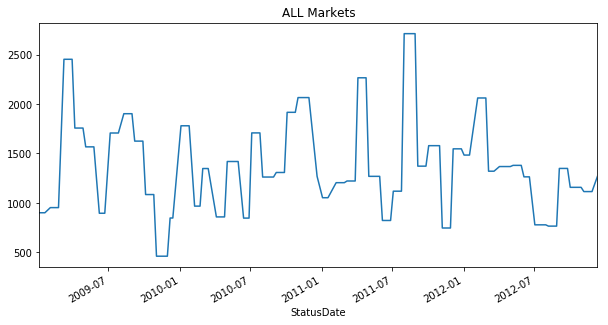

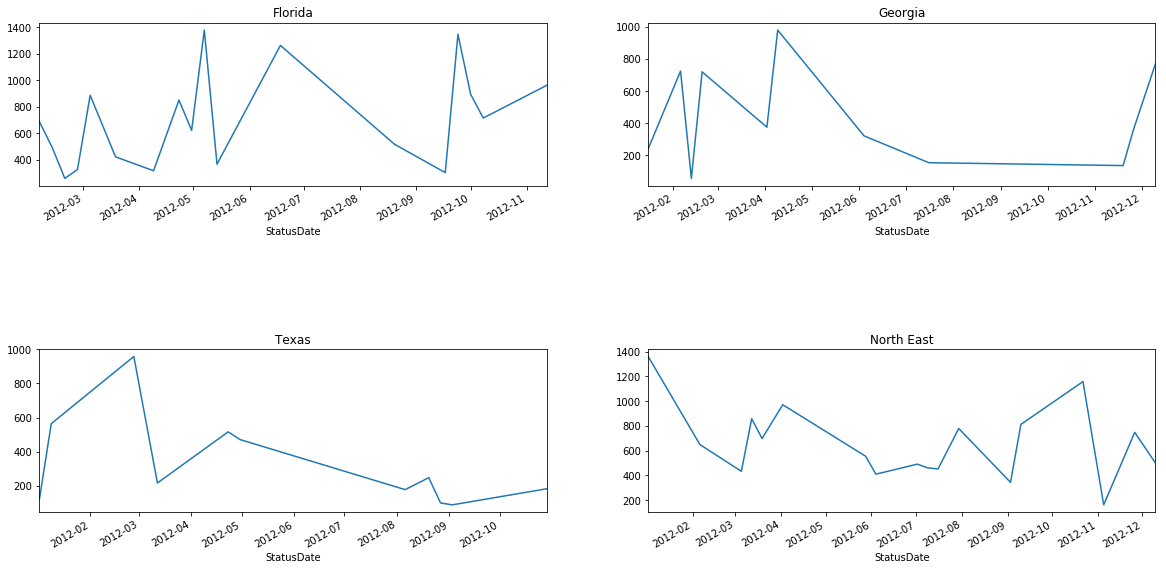

In [36]:
# 第一张图是整个市场的
ALL['Max'].plot(figsize=(10, 5));plt.title('ALL Markets')

# 后面四张
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.subplots_adjust(hspace=1.0) ## Create space between plots

Daily.loc['FL']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,0])
Daily.loc['GA']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,1]) 
Daily.loc['TX']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,0]) 
Daily.loc['NY']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,1]) 

# 增加图表的抬头
axes[0,0].set_title('Florida')
axes[0,1].set_title('Georgia')
axes[1,0].set_title('Texas')
axes[1,1].set_title('North East');

<p class="text-muted">This tutorial was created by <a href="http://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>
<p class="text-muted">本教程由<a href="http://datarx.cn" target="_blank"><strong>派兰数据</strong></a>翻译</p>

<!-- Pandas Tutorial -->  
<strong>These tutorials are also available through an email course, please visit </strong><a href="http://www.hedaro.com/pandas-tutorial" target="_blank"><strong>http://www.hedaro.com/pandas-tutorial</strong></a> <strong>to sign up today.</strong>
<!-- Pandas Tutorial -->